In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pickle

In [2]:
df =  pd.read_csv('../dataset/booking_train.csv')
df.columns = df.columns.str.lower().str.replace(' ', '_')
df['type_of_meal']=df['type_of_meal'].str.lower().str.replace(' ', '_')
df['room_type']=df['room_type'].str.lower().str.replace(' ', '_')
df['market_segment_type']=df['market_segment_type'].str.lower().str.replace(' ', '_')
df = df[~df["date_of_reservation"].str.contains("-")]
df['month_of_reservation'] = pd.to_datetime(df['date_of_reservation'],format='%m/%d/%Y').dt.strftime('%b') 
df['booking_status'] = (df.booking_status == 'Canceled').astype(int)


In [3]:
#Perform the train/validation/test split with Scikit-Learn
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df,test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train,test_size=0.25, random_state=1)
df_full_train  = df_full_train.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
y_full_train = df_full_train['booking_status'].values
y_train = df_train['booking_status'].values
y_val = df_val['booking_status'].values
y_test = df_test['booking_status'].values
del df_train['booking_status']
del df_val['booking_status']
del df_test['booking_status']


In [4]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [5]:
numerical = ['number_of_adults','number_of_children','number_of_weekend_nights','number_of_week_nights','lead_time','p-c','p-not-c','average_price','special_requests']
categorical = ['type_of_meal','room_type','market_segment_type','car_parking_space','repeated','month_of_reservation']


train_dict = df_train[categorical + numerical].to_dict(orient='records')
val_dict = df_val[categorical + numerical].to_dict(orient='records')
test_dict = df_test[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dict)
X_val = dv.transform(val_dict)
X_test = dv.transform(test_dict)
features = dv.get_feature_names_out()
features

array(['average_price', 'car_parking_space', 'lead_time',
       'market_segment_type=aviation',
       'market_segment_type=complementary',
       'market_segment_type=corporate', 'market_segment_type=offline',
       'market_segment_type=online', 'month_of_reservation=Apr',
       'month_of_reservation=Aug', 'month_of_reservation=Dec',
       'month_of_reservation=Feb', 'month_of_reservation=Jan',
       'month_of_reservation=Jul', 'month_of_reservation=Jun',
       'month_of_reservation=Mar', 'month_of_reservation=May',
       'month_of_reservation=Nov', 'month_of_reservation=Oct',
       'month_of_reservation=Sep', 'number_of_adults',
       'number_of_children', 'number_of_week_nights',
       'number_of_weekend_nights', 'p-c', 'p-not-c', 'repeated',
       'room_type=room_type_1', 'room_type=room_type_2',
       'room_type=room_type_3', 'room_type=room_type_4',
       'room_type=room_type_5', 'room_type=room_type_6',
       'room_type=room_type_7', 'special_requests',
       'typ

In [9]:
rf = RandomForestClassifier(n_estimators=2)
rf.fit(X_train, y_train)
y_pred = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.8801356634023526

In [19]:
auc_scores=[]
for i in [2,5,8,10,15,20,25,30,50,75,100]:
    rf = RandomForestClassifier(n_estimators=i,random_state=5)
    rf.fit(X_train, y_train)
    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    auc_scores.append((i,auc))
auc_scores    

[(2, 0.8843045579703434),
 (5, 0.9249649851099004),
 (8, 0.9351791232664473),
 (10, 0.9382178403321011),
 (15, 0.9433776685696804),
 (20, 0.9450950822674493),
 (25, 0.9457536288477785),
 (30, 0.9472042645188997),
 (50, 0.9494940032615071),
 (75, 0.9500581271735195),
 (100, 0.9505653255753248)]

In [21]:
#max_depth

auc_map = {}

for depth in [5, 10, 15, 20]:
    print('depth: %s' % depth)
    auc_scores = []

    for i in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=i, max_depth=depth, random_state=5)
        rf.fit(X_train, y_train)
        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        print('%s -> %.3f' % (i, auc))
        auc_scores.append(auc)
    
    auc_map[depth] = auc_scores
    print()

depth: 5
10 -> 0.866
20 -> 0.874
30 -> 0.877
40 -> 0.880
50 -> 0.879
60 -> 0.878
70 -> 0.879
80 -> 0.880
90 -> 0.879
100 -> 0.881
110 -> 0.881
120 -> 0.881
130 -> 0.882
140 -> 0.881
150 -> 0.881
160 -> 0.882
170 -> 0.884
180 -> 0.884
190 -> 0.884
200 -> 0.883

depth: 10
10 -> 0.916
20 -> 0.923
30 -> 0.926
40 -> 0.927
50 -> 0.927
60 -> 0.927
70 -> 0.927
80 -> 0.927
90 -> 0.927
100 -> 0.927
110 -> 0.927
120 -> 0.927
130 -> 0.926
140 -> 0.926
150 -> 0.926
160 -> 0.927
170 -> 0.927
180 -> 0.927
190 -> 0.926
200 -> 0.926

depth: 15
10 -> 0.938
20 -> 0.942
30 -> 0.944
40 -> 0.945
50 -> 0.945
60 -> 0.945
70 -> 0.946
80 -> 0.946
90 -> 0.946
100 -> 0.946
110 -> 0.947
120 -> 0.947
130 -> 0.947
140 -> 0.947
150 -> 0.947
160 -> 0.947
170 -> 0.947
180 -> 0.947
190 -> 0.947
200 -> 0.947

depth: 20
10 -> 0.945
20 -> 0.949
30 -> 0.951
40 -> 0.952
50 -> 0.952
60 -> 0.952
70 -> 0.953
80 -> 0.953
90 -> 0.953
100 -> 0.953
110 -> 0.953
120 -> 0.953
130 -> 0.953
140 -> 0.953
150 -> 0.953
160 -> 0.953
170 ->

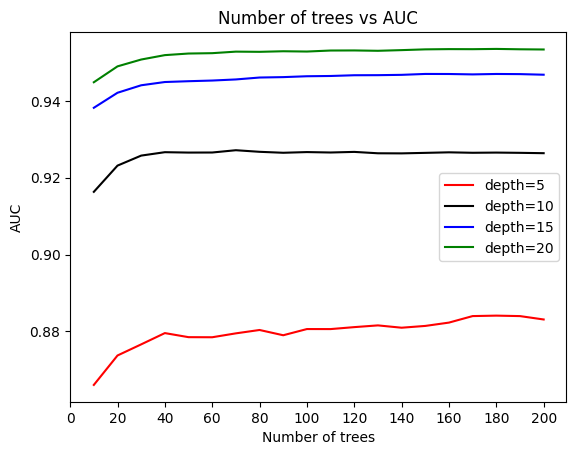

In [27]:
num_trees = list(range(10, 201, 10))

plt.plot(num_trees, auc_map[5], label='depth=5', color='red', linestyle='solid')
plt.plot(num_trees, auc_map[10], label='depth=10', color='black', linestyle='solid')
plt.plot(num_trees, auc_map[15], label='depth=15', color='blue', linestyle='solid')
plt.plot(num_trees, auc_map[20], label='depth=20', color='green', linestyle='solid')
    
plt.xticks(range(0, 201, 20))
plt.legend()

plt.title('Number of trees vs AUC')
plt.xlabel('Number of trees')
plt.ylabel('AUC')


plt.show()

In [ ]:
# max_depth =20 and estimator= 30 gives 0.95 auc

In [46]:
# Tune min_samples_leaf
auc_map = {}

for min_samples in [2, 5, 10, 15, 20]:
    print('min_samples_leaft: %s' % min_samples)
    auc_scores = []

    for i in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=i, max_depth=20, random_state=1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        print('%s -> %.3f' % (i, auc))
        auc_scores.append(auc)
    
    auc_map[min_samples] = auc_scores
    print()

min_samples_leaft: 2
10 -> 0.943
20 -> 0.948
30 -> 0.951
40 -> 0.951
50 -> 0.952
60 -> 0.952
70 -> 0.952
80 -> 0.953
90 -> 0.953
100 -> 0.953
110 -> 0.953
120 -> 0.953
130 -> 0.953
140 -> 0.953
150 -> 0.953
160 -> 0.953
170 -> 0.953
180 -> 0.953
190 -> 0.953
200 -> 0.953

min_samples_leaft: 5
10 -> 0.943
20 -> 0.948
30 -> 0.951
40 -> 0.951
50 -> 0.952
60 -> 0.952
70 -> 0.952
80 -> 0.953
90 -> 0.953
100 -> 0.953
110 -> 0.953
120 -> 0.953
130 -> 0.953
140 -> 0.953
150 -> 0.953
160 -> 0.953
170 -> 0.953
180 -> 0.953
190 -> 0.953
200 -> 0.953

min_samples_leaft: 10
10 -> 0.943
20 -> 0.948
30 -> 0.951
40 -> 0.951
50 -> 0.952
60 -> 0.952
70 -> 0.952
80 -> 0.953
90 -> 0.953
100 -> 0.953
110 -> 0.953
120 -> 0.953
130 -> 0.953
140 -> 0.953
150 -> 0.953
160 -> 0.953
170 -> 0.953
180 -> 0.953
190 -> 0.953
200 -> 0.953

min_samples_leaft: 15
10 -> 0.943
20 -> 0.948
30 -> 0.951
40 -> 0.951
50 -> 0.952
60 -> 0.952
70 -> 0.952
80 -> 0.953
90 -> 0.953
100 -> 0.953
110 -> 0.953
120 -> 0.953
130 -> 0.95

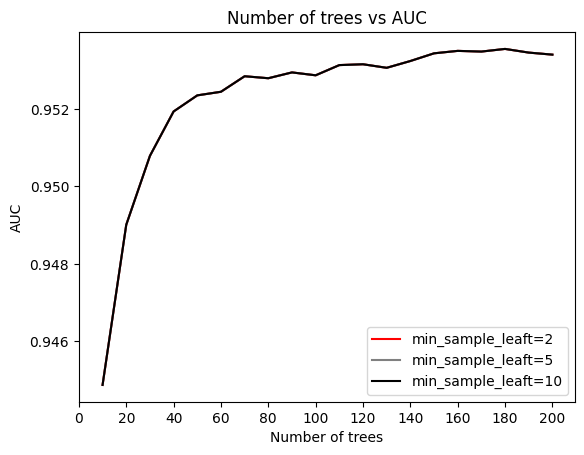

In [37]:
num_trees = list(range(10, 201, 10))

plt.plot(num_trees, auc_map[2], label='min_sample_leaft=2', color='red', linestyle='solid')
plt.plot(num_trees, auc_map[5], label='min_sample_leaft=5', color='grey', linestyle='solid')
plt.plot(num_trees, auc_map[10], label='min_sample_leaft=10', color='black', linestyle='solid')
plt.plot(num_trees, auc_map[15], label='min_sample_leaft=15', color='blue', linestyle='solid')
plt.plot(num_trees, auc_map[20], label='min_sample_leaft=20', color='green', linestyle='solid')
    
plt.xticks(range(0, 201, 20))
plt.legend()

plt.title('Number of trees vs AUC')
plt.xlabel('Number of trees')
plt.ylabel('AUC')


plt.show()

In [41]:
#min_sample_size looks simimlar at estimator=30, max_depth 20, min_samples=5
#final model

def train(df, y):
    data = df[categorical + numerical].to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    dv.fit(data)
    X = dv.transform(data)
    model = RandomForestClassifier(n_estimators=30, max_depth=20, min_samples_leaf=5, random_state=5)
    model.fit(X_train, y_train)
    return dv, model


def predict(df, dv, model):
    data = df[categorical + numerical].to_dict(orient='records')
    
    X = dv.transform(data)

    y_pred = model.predict_proba(X)[:, 1]

    return y_pred


In [52]:
dv, model = train(df_train, y_train)
y_train_pred = predict(df_train, dv, model)
y_val_pred = predict(df_val, dv, model)
y_test_pred = predict(df_test, dv, model)
train_auc = roc_auc_score(y_train, y_train_pred)
val_auc = roc_auc_score(y_val, y_val_pred)
test_auc = roc_auc_score(y_test, y_test_pred)

train_auc,test_auc

print('train_auc - %.3f, val_auc - %.3f, test_auc - %.3f' % (train_auc, val_auc, test_auc))


#no overfitting found.

train_auc - 0.965, val_auc - 0.942, test_auc - 0.934


In [53]:
dv, model = train(df_full_train, y_full_train)
model

RandomForestClassifier(max_depth=20, min_samples_leaf=5, n_estimators=30,
                       random_state=5)

In [54]:
y_pred = predict(df_test, dv, model)
auc = roc_auc_score(y_test, y_pred)
auc

0.934335885506027

In [57]:
with open('../model/cancellation-pred-model-random-forest.bin', 'wb') as f_out:
    pickle.dump((dv,model),f_out)

In [ ]:
#test auc - 0.934335885506027, which is 1% better than decision tree